# Melting Uncertainties

This aims to estimate the uncertainty of the crystal melting rates,
combining the uncertainties of the dynamics and that of the rates calculation.

In [29]:
import pandas
import uncertainties
import altair as alt
import numpy as np
import scipy.optimize

import sys
sys.path.append("../src")
import figures

figures.use_my_theme()

## Error in Melting Rates

The error of the melting rates will be calculated
by taking the standard deviation of all the measurements

In [2]:
with pandas.HDFStore('../data/analysis/melting_clean.h5') as store:
    rates_df = store.get("rates")

In [3]:
rates_df["error_min"] = rates_df["mean"] - 2*rates_df["error"]
rates_df["error_max"] = rates_df["mean"] + 2*rates_df["error"]

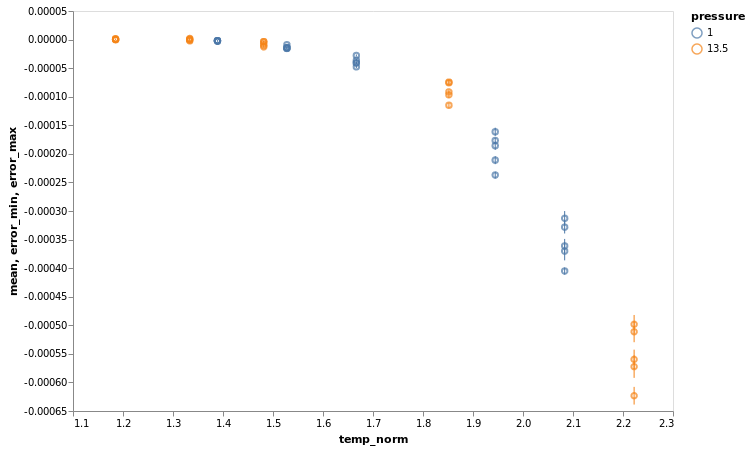

In [4]:
chart = alt.Chart(rates_df).encode(
    x=alt.X("temp_norm", scale=alt.Scale(zero=False)),
    color="pressure:N",
)

chart.mark_point().encode(y="mean") + chart.mark_rule().encode(y="error_min", y2="error_max")

In [5]:
melt_value = rates_df.groupby(["temperature","pressure", "temp_norm"])["mean"].mean()
melt_err = rates_df.groupby(["temperature", "pressure", "temp_norm"])["mean"].std()
melt_frac_err = melt_err / melt_value
melt_df = pandas.DataFrame({
    "value": melt_value,
    "error": melt_err,
    "error_frac": melt_frac_err,
    "error_min": melt_value - 2 * melt_err,
    "error_max": melt_value + 2 * melt_err,
})

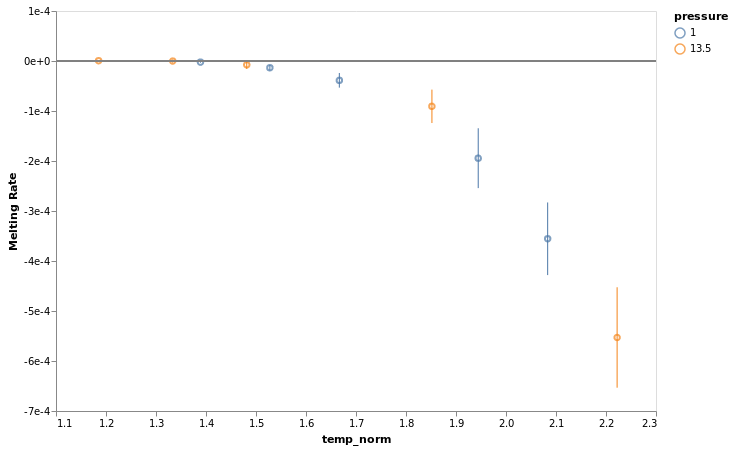

In [6]:
chart = alt.Chart(melt_df.reset_index()).encode(
    x=alt.X("temp_norm", scale=alt.Scale(zero=False)),
    color="pressure:N",
)

chart = (
    chart.mark_point().encode(y=alt.Y("value", title="Melting Rate", axis=alt.Axis(format='e'))) +
    chart.mark_rule().encode(y="error_min", y2="error_max")
)

chart = figures.hline(chart, 0)
chart

In [7]:
chart.save("../figures/growth_rates_err.svg", webdriver="firefox")

In [8]:
mean = rates_df.groupby(["temperature","pressure", "temp_norm"])["mean"].mean()
err = rates_df.groupby(["temperature", "pressure", "temp_norm"])["mean"].std()

## Error in Rotational Relaxation

In [9]:
with pandas.HDFStore('../data/analysis/dynamics_clean_agg.h5') as store:
    relax_df = store.get("relaxations")

In [10]:
rot_value = relax_df.groupby(["temperature", "pressure"])["rot2_value"].mean()
rot_err = np.maximum((relax_df["rot2_value"] - relax_df["rot2_lower"]).values, (relax_df["rot2_upper"] - relax_df["rot2_value"]).values)
rot_frac_err = rot_err / rot_value

rot_df = pandas.DataFrame({
    "value": rot_value,
    "error": rot_err,
    "error_frac": rot_frac_err,
})

In [11]:
all_df = melt_df.reset_index("temp_norm").join(rot_df, lsuffix="_melt", rsuffix="_rot").set_index('temp_norm', append=True)
all_df.head()

,,,value_melt,error_melt,error_frac_melt,error_min,error_max,value_rot,error_rot,error_frac_rot
temperature,pressure,temp_norm,,,,,,,,
0.50,1.0,1.388889,-0.000002,5.687361e-07,-0.243847,-0.000003,-0.000001,58404.0,516.3,0.008840
0.55,1.0,1.527778,-0.000014,2.629955e-06,-0.194070,-0.000019,-0.000008,35660.0,400.0,0.011217
0.60,1.0,1.666667,-0.000039,7.319678e-06,-0.189497,-0.000053,-0.000024,22080.0,280.0,0.012681
0.70,1.0,1.944444,-0.000194,2.992831e-05,-0.153981,-0.000254,-0.000135,12680.0,301.0,0.023738
0.75,1.0,2.083333,-0.000356,3.631051e-05,-0.102123,-0.000428,-0.000283,NaN,NaN,NaN


In [32]:
value = all_df["value_melt"] * all_df["value_rot"]
err_frac = all_df["error_frac_melt"].abs() + all_df["error_frac_rot"].abs()
error = value * err_frac

melt_values = pandas.DataFrame({
    "value": value,
    "error": error,
    "error_min": value - 2 * error,
    "error_max": value + 2 * error,
}).reset_index().dropna()

In [33]:
chart = alt.Chart(melt_values).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

c = (
    chart.mark_point().encode(y=alt.Y("value", title="Rotational Relaxation × Melting Rate")) +
    chart.mark_rule().encode(y="error_min", y2="error_max")
)

c = figures.hline(c, 0)

In [34]:
c.save("../figures/normalised_melting_err.svg", webdriver="firefox")

## Fitting to Theory

When fitting a curve to the data
it is required to take into account
the errors in the data.

In [35]:
def fit_curve(x_vals, y_vals, errors=None, delta_E=None):
    if delta_E is None:
        def theory(x, c, d):
            result = 1 - np.exp((1-x) * d / x)
            return c * result
    else:
        def theory(x, c):
            result = 1 - np.exp((1-x) * delta_E / x)
            return c * result
    
    opt, err = scipy.optimize.curve_fit(
        theory, 
        x_vals, 
        y_vals,
        sigma=errors,
    )
    
    return theory, opt, err

In [85]:
import matplotlib.pyplot as plt

x = np.arange(0.95, 2.0, 0.05)

p1_values = melt_values.query("pressure == 1.00")
p13_values = melt_values.query("pressure == 13.50")

theory1, opt1, err1 = fit_curve(p1_values["temp_norm"], p1_values["value"], p1_values["error"], -0.18034612159032992)
theory13, opt13, err13 = fit_curve(p13_values["temp_norm"], p13_values["value"], p13_values["error"], -0.06561802006526474)

In [86]:
y1 = theory1(x, *opt1)
y13 = theory13(x, *opt13)

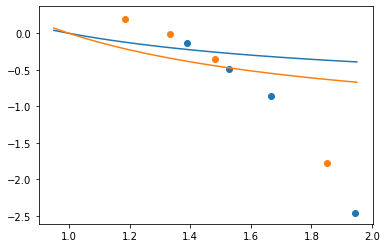

In [88]:
plt.plot(x, y1)
plt.scatter(p1_values["temp_norm"], p1_values["value"])
plt.plot(x, y13)
plt.scatter(p13_values["temp_norm"], p13_values["value"])
plt.savefig("theory_fits.pdf")